# Designing a forgetting attack for a known semantic space

If

1. memory behaves like our model
2. we know the nodes and weighted edges in a person's semantic space

can we find a sequence of node activations that will make them forget a set of target words?

In [205]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, '../')

import copy
import string

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import gensim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import graphsemnet.gsn_recursive as gsn
import graphsemnet.semantics as sem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
sns.set(font_scale=1.5)

## Pull a target semantic space from the Google News pretrained word2vec space

In [3]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [465]:
words = [
    'literature',
    'fiction',
    'fact',
    'deceive',
    'Trump',
    'republican',
    'democrat', 
    'liberal', 
    'conservative',
    'politician',
    'earthquake',
    'tornado',
]

In [466]:
# Build a keyed vector dictionary, omitting words that are not in the corpus
my_dsm, my_labels = sem.semantic_dsm_safe(words, google_news)
my_graph = gsn.SemanticGraph(word_dsm=my_dsm, labels=my_labels)
my_graph.set_xcal(
    dip_center=.2,
    dip_width=.2,
    min_adjust=-.025,
    max_adjust=.05
)

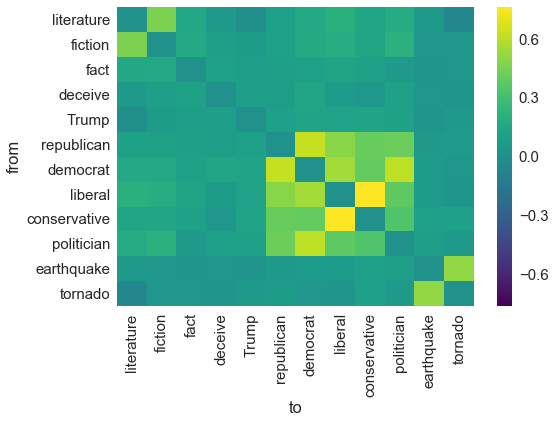

In [467]:
fig, ax = plt.subplots()
sns.heatmap(
    my_graph.adj, 
    xticklabels=my_graph.labels, 
    yticklabels=my_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')

## Find the activation that most decreases the in-degree of a word

### Monte carlo search

In [468]:
def obj(activation):
    g = copy.deepcopy(my_graph)
    current_state = np.mean(g.adj[:, 5])
    acts = g.activate_hebb(activation, decay=.7)
    g.weight_adjust_hebb(acts)
    new_state = np.mean(g.adj[:, 5])
    return current_state - new_state

In [469]:
def monte_carlo_search(graph, n):
    results = []
    for _ in range(n):
        activation = np.random.randint(0, 2, size=len(graph.labels))
        results.append((activation, obj(activation)))
    results = sorted(results, key=lambda x: -x[1])
    return results

In [446]:
results = monte_carlo_search(my_graph, 100)
results[0:10]

[(array([1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]), 0.016066658909407117),
 (array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0]), 0.016034631687172396),
 (array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 0.015171492499462341),
 (array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]), 0.0055061376460484035),
 (array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]), 0.0049476506194667258),
 (array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1]), -0.0016092388717055539),
 (array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]), -0.0035481527157929238),
 (array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]), -0.0059831906172884974),
 (array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]), -0.014167734142324862),
 (array([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]), -0.015615503032983147)]

In [447]:
[g.labels[i] for i in np.argwhere(results[0][0]).T[0]]

['literature', 'fiction', 'Trump', 'tornado']

Activating these words should maximally decrease connections to the target word (modulo the effects of whatever other words you need to add to shoehorn them all into a reasonable sentence).

### Exhaustive search

In [448]:
import itertools

In [449]:
def exhaustive_search(graph):
    binary_activations = list(map(list, itertools.product([0, 1], repeat=len(graph.labels))))
    results = []
    for activation in binary_activations:
        results.append((activation, obj(np.array(activation))))
    results = sorted(results, key=lambda x: -x[1])
    return results

In [450]:
# Takes a minute
results = exhaustive_search(my_graph)
results[0:10]

[([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.041896554315938195),
 ([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.041269724223755827),
 ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.040052320757600401),
 ([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1], 0.039739043018166276),
 ([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1], 0.039347103933179528),
 ([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.037936572182876771),
 ([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], 0.037852581599229773),
 ([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], 0.037357534970247797),
 ([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], 0.037322486006170025),
 ([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1], 0.037121078895839099)]

In [456]:
[my_graph.labels[i] for i in np.argwhere(results[0][0]).T[0]]

['literature', 'Trump', 'tornado']

### Iteratively applying the activation that creates the most forgetting

In [470]:
max_iterations = 10
for _ in range(max_iterations):
    print("Searching...")
    best_result = monte_carlo_search(my_graph, 500)[0]
    if best_result[1] > 0:
        words = [my_graph.labels[i] for i in np.argwhere(best_result[0]).T[0]]
        print(words)
        acts = my_graph.activate_hebb(best_result[0], decay=.7)
        my_graph.weight_adjust_hebb(acts)
    else:
        print("stabilized")
        break

Searching...
['fiction', 'deceive', 'earthquake', 'tornado']
Searching...
['literature', 'fiction', 'deceive', 'Trump', 'tornado']
Searching...
['conservative', 'earthquake', 'tornado']
Searching...
['literature', 'fiction', 'Trump', 'conservative', 'tornado']
Searching...
['literature', 'deceive', 'Trump', 'politician', 'tornado']
Searching...
['fiction', 'fact', 'deceive', 'liberal']
Searching...
['fact', 'Trump', 'conservative', 'politician', 'earthquake']
Searching...
['fiction']
Searching...
['literature', 'fiction', 'deceive', 'Trump', 'democrat', 'tornado']
Searching...
['fact', 'politician']


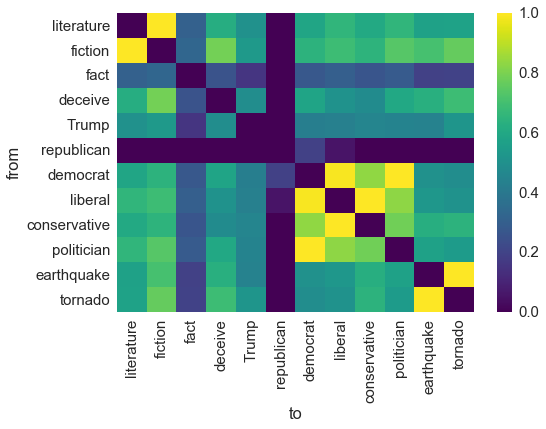

In [471]:
fig, ax = plt.subplots()
sns.heatmap(
    my_graph.adj, 
    xticklabels=my_graph.labels, 
    yticklabels=my_graph.labels, 
    cmap='viridis'
)
plt.xlabel('to')
plt.ylabel('from')

<img src='sunshine.jpg'>